# DC2 Object Catalog Run1.2i GCR tutorial -- Part IV: accessing photo-z

Owners: **Yao-Yuan Mao [@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao)**, 
        **Sam Schmidt [@sschmidt23](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@sschmidt23)**

Last Verifed to Run: **2019-02-25** (by @yymao)

This notebook will show you how to access the "add-on" columns that provide the photometric redshift (photo-z) information for the DC2 Object Catalog (Run 1.2i). 

__Learning objectives__: After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 object catalog (+ photo-z) with the GCR
  2. Understand how the photo-z data are stored / represented
  3. Look at an example of galaxy photo-z distributions
  
__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

__Other notes__: 
If you restart your kernel, or if it automatically restarts for some reason, all imports and variables will become undefined so, you will have to re-run everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import GCRCatalogs
from GCR import GCRQuery

## Load the catalog

Loading the object catalog with photo-z add-on. The catalog name is `dc2_object_run1.2i_with_photoz`. 

**Note**: if you need more quantities (including those not in DPDD), then use `dc2_object_run1.2i_all_columns_with_photoz` instead.

It takes a few seconds for the catalog instance to initiate.

In [3]:
cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_with_photoz')

## Photo-z access methods

The photo-z infomation can be accessed in two ways:

1. As a single column `photoz_mode` that has the mode value (z_peak), and
2. As a single multi-dimensional column `photoz_pdf` 
   (i.e., when accessing this column, you get a 2D array (objects x PDF values) instead of a 1D array). 
   Note that the column contains only the PDF values, not the bin center values. 
   The PDF bin centers are stored in a catalog attribute named `photoz_pdf_bin_centers`. 

We will demonstrate both access methods in detail. You can notice that all the photo-z columns have a prefix of `photoz_`. 

Let's first make sure that these columns are indeed available. 

In [4]:
sorted(q for q in cat.list_all_quantities() if q.startswith('photoz_'))

['photoz_mode', 'photoz_pdf']

Let's now try access the photo-z data! Everything you already about the GCR access of object catalogs will still apply. 
Including the use of `filters` and `native_filters` (`native_filters` is used for selecting tracts mostly). 

In [5]:
data = cat.get_quantities(['photoz_mode'], 
                          filters=['photoz_mode < 0.2', 'mag_i < 26'], 
                          native_filters=['tract==4850'])

# check if the filters work
print((data['photoz_mode'] < 0.2).all())

True


Now, if you want to make a plot of the PDF, it might be easier to access the `photoz_pdf` column. Note that it is a multi-dimensional column, so use with care!

As an example, let's just load one patch (using the `return_iterator` feature) of the full PDFs and also peak values at the same time:

In [6]:
data = next(cat.get_quantities(['photoz_pdf', 'photoz_mode'], return_iterator=True))

There are 72 objects in this patch, and there are 101 bins in the photo-z PDF, so this 2D array has a shape of (72, 101). Note how the 2D array is oriented.

In [7]:
data['photoz_pdf'].shape

(72, 101)

In [8]:
print (data['photoz_mode'][:10])

[0.855 0.855 0.855 0.715 0.905 0.915 0.855 0.605 0.475 0.455]


Now, let's plot 10 PDFs. The PDFs were evaluated on a set grid of redshift values.  For run1.2 this grid only extended to z=1.0, as the protoDC2 catalog only covered this range, for future releases the photo-z range will expand to higher redshift. <br>
To get the array of bin center values, you can access the `pz_pdf_bin_centers` attribute. 

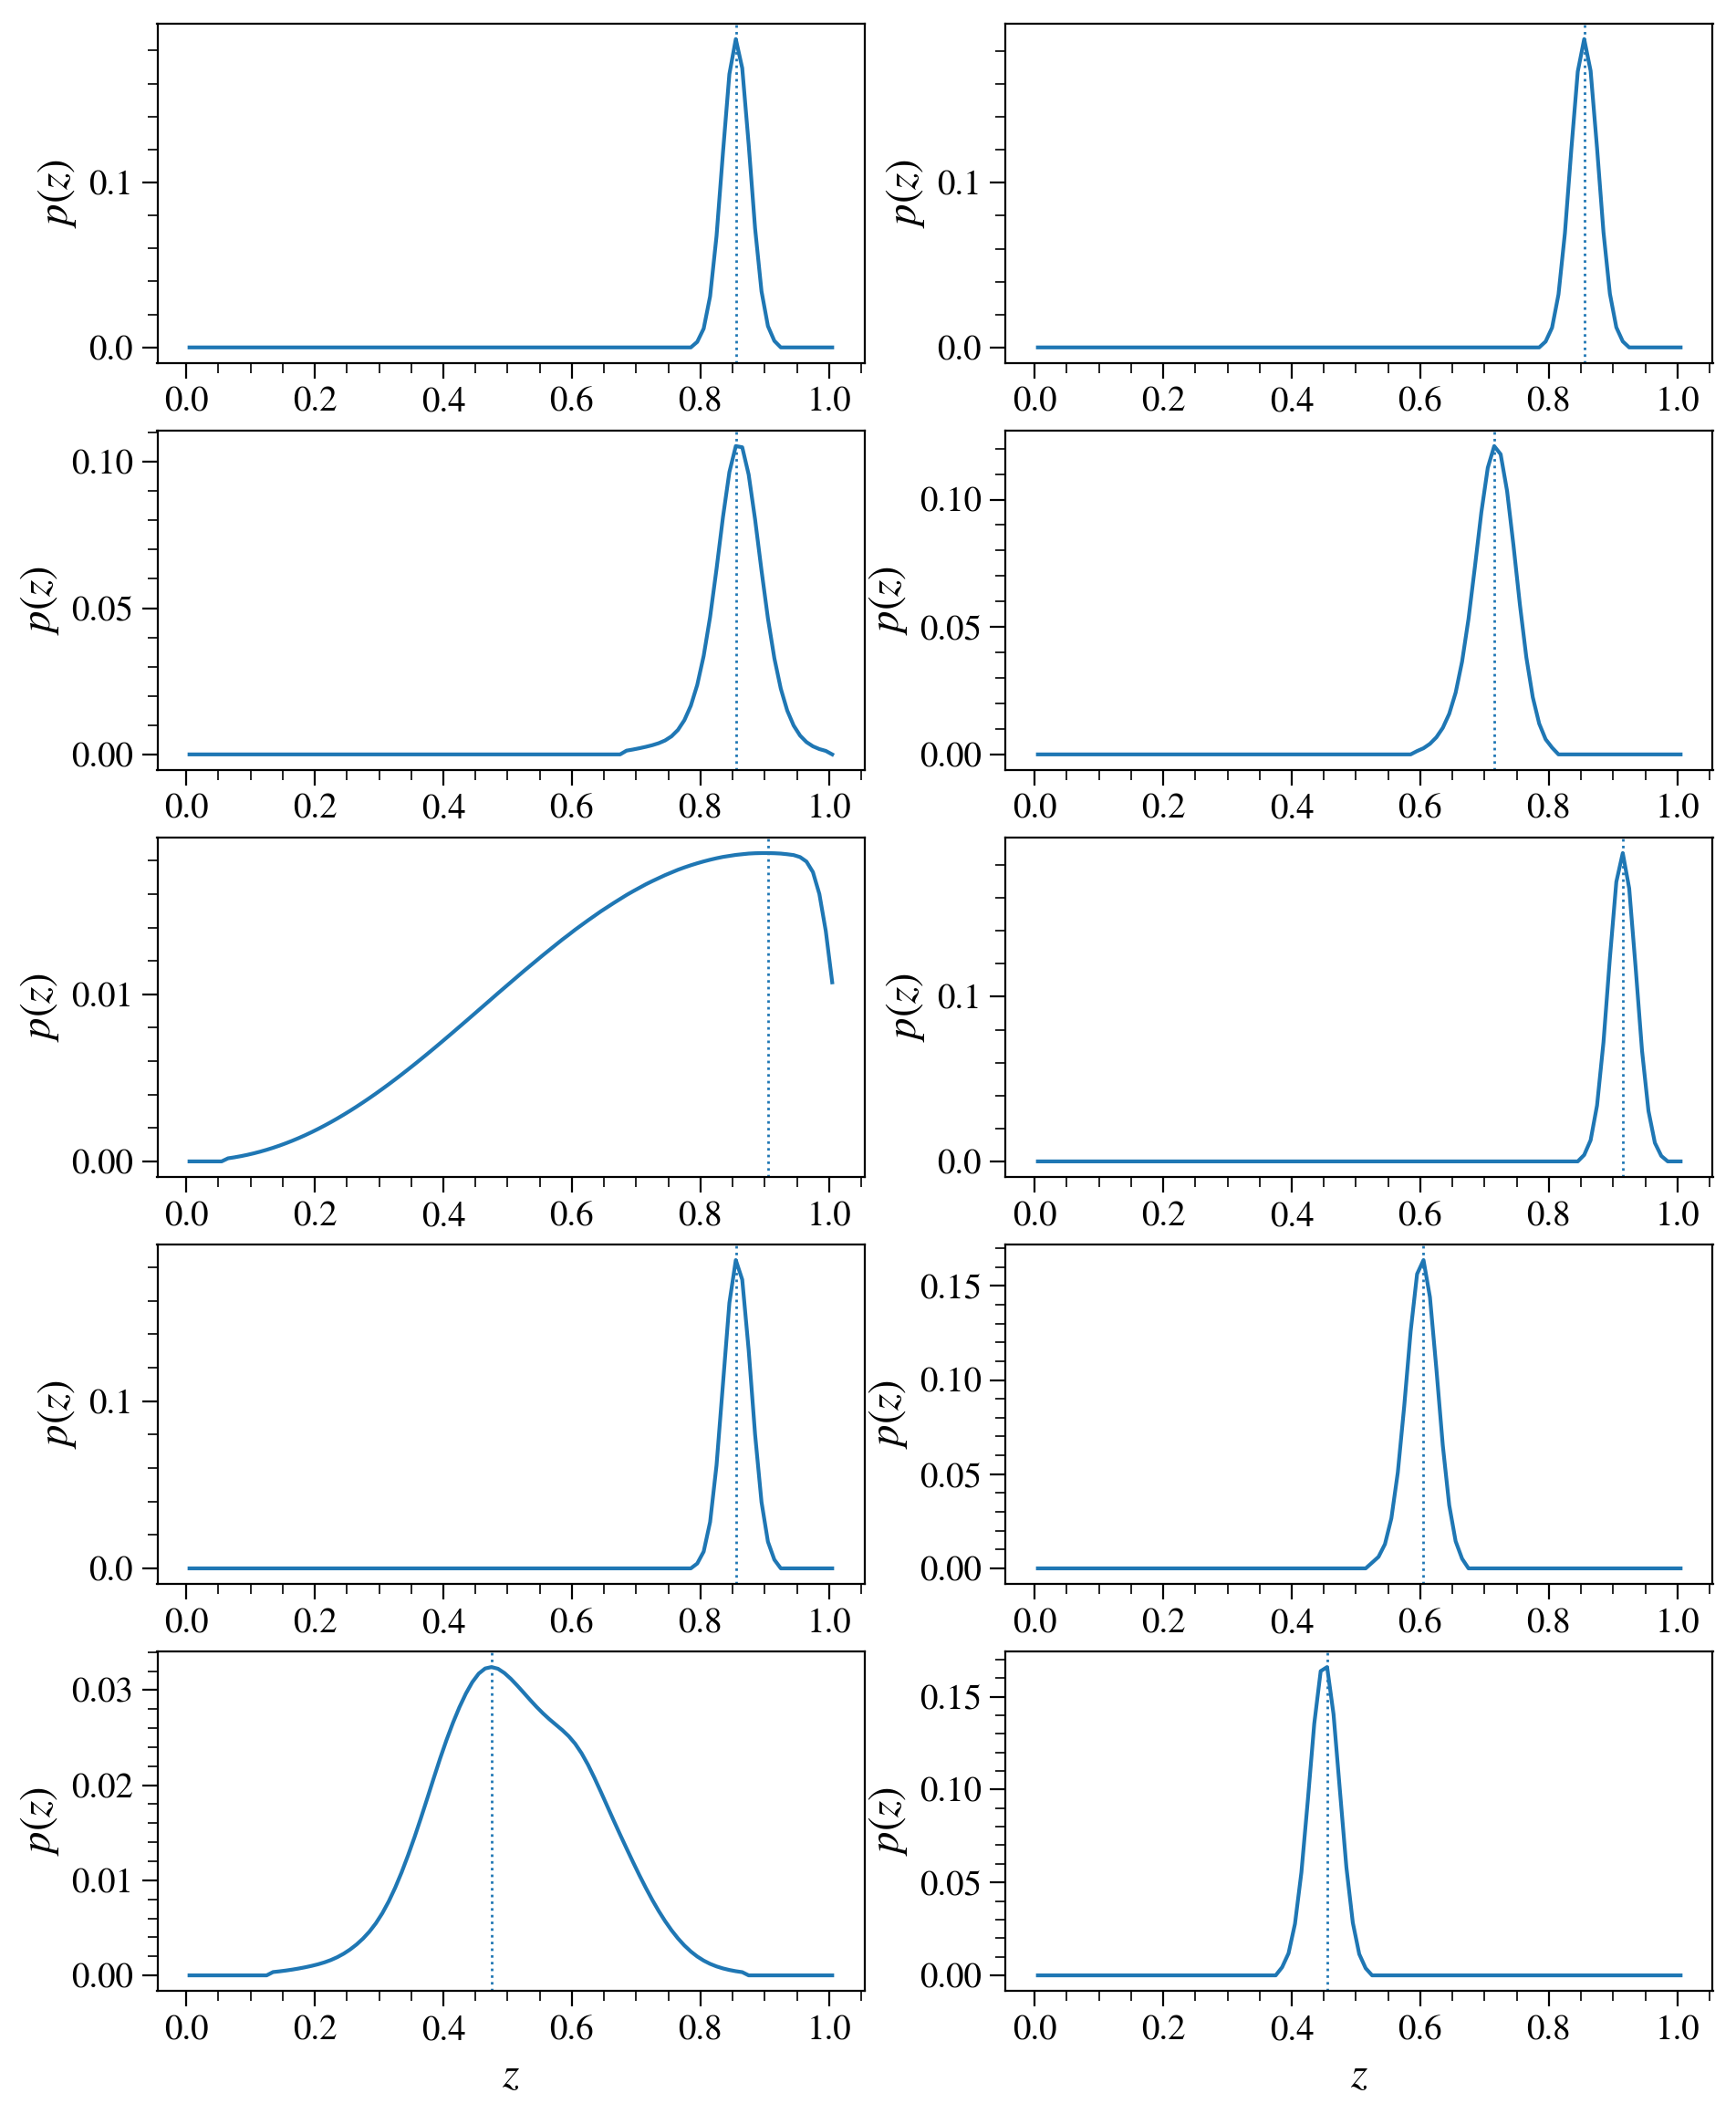

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(11,14))
for pdf, z_peak, ax_this in zip(data['photoz_pdf'], data['photoz_mode'], ax.flat):
    l = ax_this.plot(cat.photoz_pdf_bin_centers, pdf);
    ax_this.axvline(z_peak, color=l[0].get_color(), ls=':', lw=1);
    ax_this.set_xlabel('$z$');
    ax_this.set_ylabel('$p(z)$');

Note that these PDFs only go to $z=1$. This is because the photo-z catalog presented here is just a test catalog, and Run 1.2x is using protoDC2, which only contains galaxies up to $z=1$. 

## Example

Now that we have learned all the access methods, let's try to work out an example!

First of all, let's define a set of reasonable cuts to give us galaxies

In [10]:
cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('snr_i_cModel > 20'),    # SNR > 10
    GCRQuery('snr_r_cModel > 20'),
    GCRQuery('snr_g_cModel > 20'),
    GCRQuery('mag_i_cModel < 22'),  # cModel imag brighter than 22
    GCRQuery('mag_i_cModel > 20')  # cModel imag fainter than 20 (exclude super bright objects)
]

Now let's make some plots!  Let's compare the histogram of photoz_mode values to the sum of the individual PDF values, the "stacked" PDF being a common (but not statistically correct) way of estimating redshift distributions:

In [11]:
data = cat.get_quantities(['photoz_mode', 'mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel','photoz_pdf'], filters=cuts, native_filters=['tract==4850'])

In [12]:
sumpdf = np.sum(data['photoz_pdf'],axis=0)

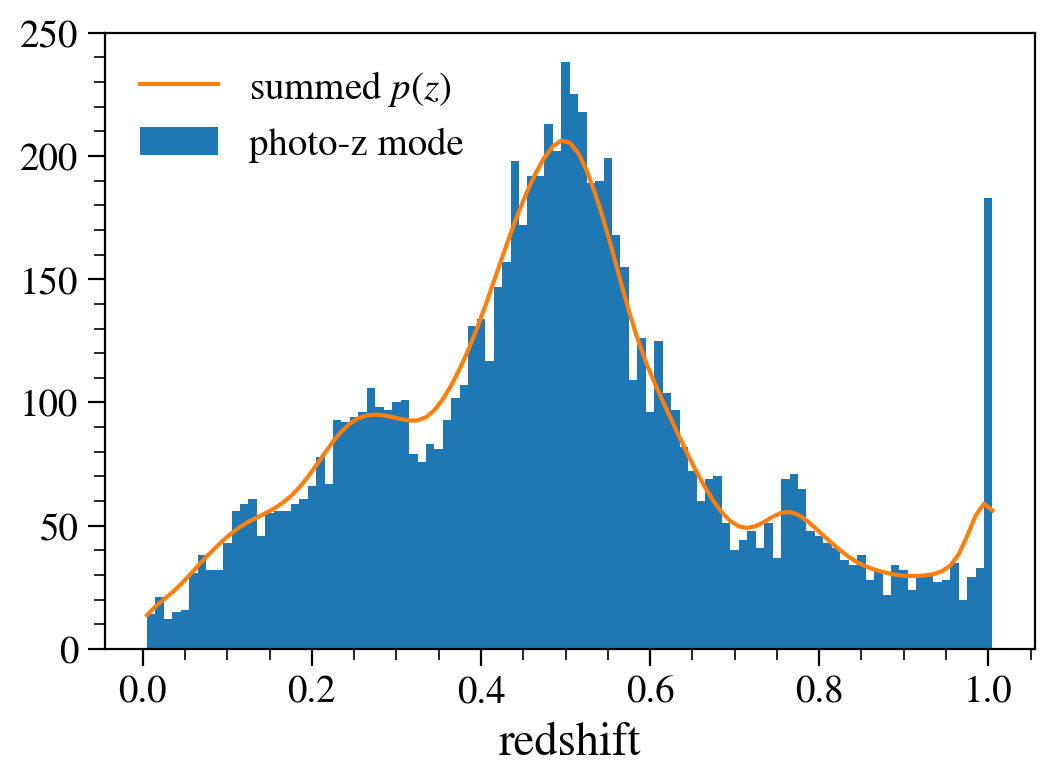

In [13]:
plt.hist(data['photoz_mode'], 100, label="photo-z mode");
plt.plot(cat.photoz_pdf_bin_centers, sumpdf,label="summed $p(z)$");
plt.xlabel("redshift");
plt.legend(loc='upper left');

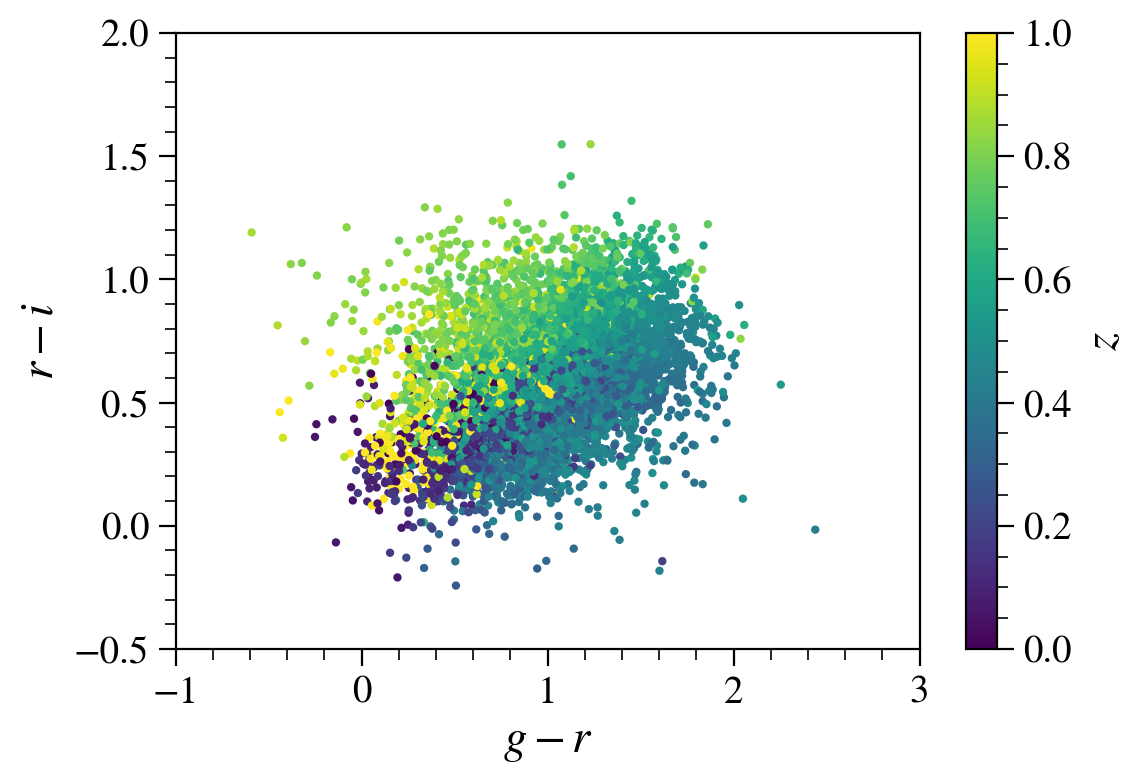

In [14]:
plt.scatter(data['mag_g_cModel'] - data['mag_r_cModel'],
            data['mag_r_cModel'] - data['mag_i_cModel'],
            c=data['photoz_mode'], s=4, vmin=0, vmax=1);

plt.xlim(-1, 3);
plt.ylim(-0.5, 2);
plt.xlabel('$g-r$');
plt.ylabel('$r-i$');
plt.colorbar(label='$z$');

# Food for thought: Look at how the photo-z values are distributed in this color-color space. Is this behavior expected?

We can see a strong correlation between redshift and position in color space, however the colors are determined by both the SED shape and redshift, so we also see degenerate areas, particularly at the blue end near color = 0.0 where low and high redshift solutions are close in color space.

Let's also examine a tomographic slice selected in terms of photoz_mode:

In [15]:
bin_cut = GCRQuery('photoz_mode > 0.6', 'photoz_mode < 0.8').mask(data)
sumpdf_bin = np.sum(data['photoz_pdf'][bin_cut],axis=0)

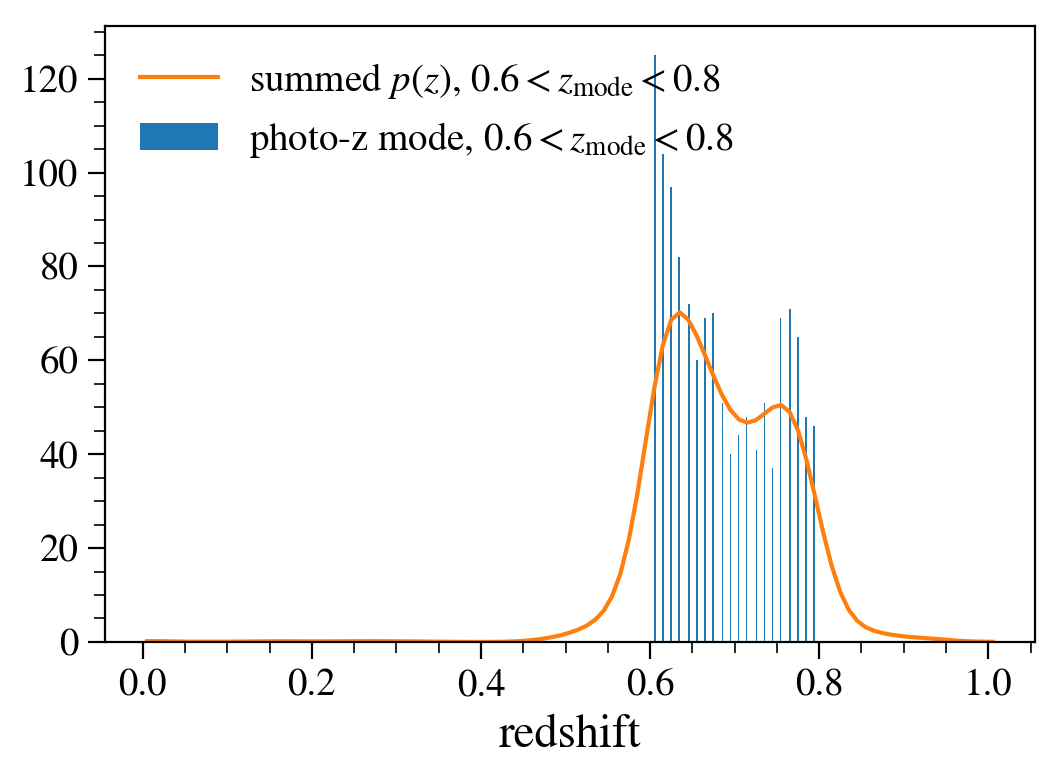

In [16]:
plt.hist(data['photoz_mode'][bin_cut], 100, label=r'photo-z mode, $0.6 < z_{\rm mode} < 0.8$');
plt.plot(cat.photoz_pdf_bin_centers, sumpdf_bin, label=r'summed $p(z)$, $0.6 < z_{\rm mode} < 0.8$');
plt.xlabel("redshift");
plt.legend(loc='upper left');

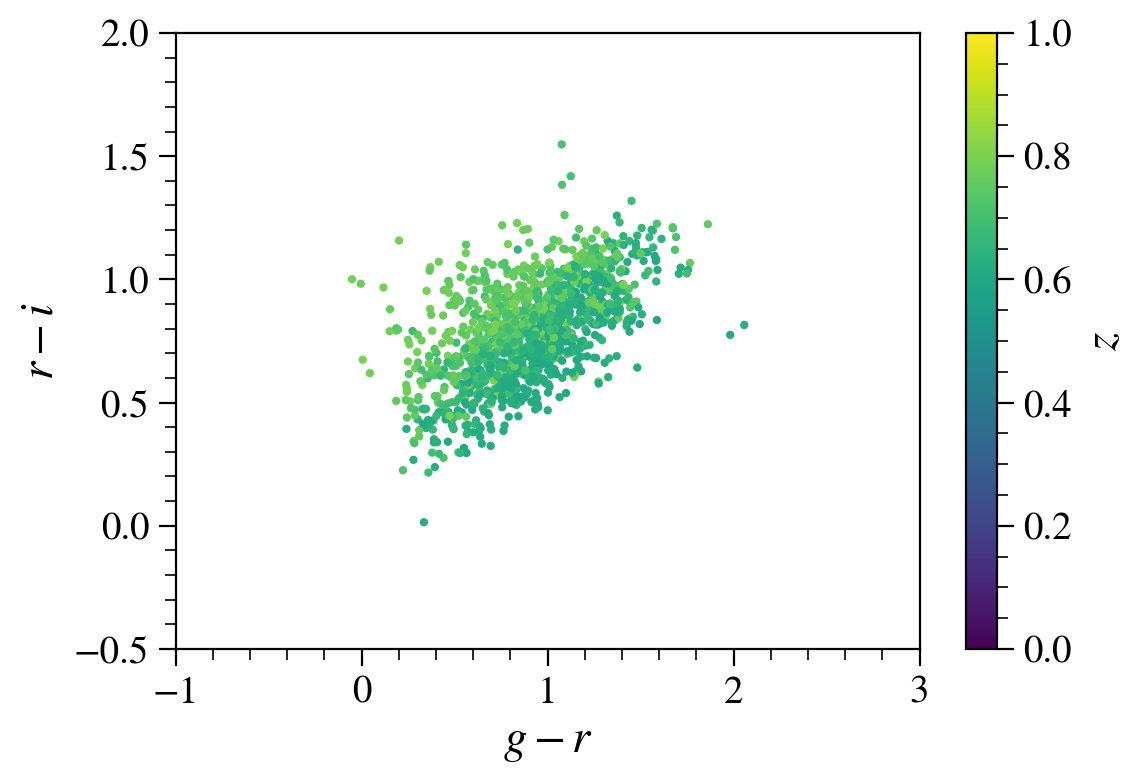

In [17]:
plt.scatter(data['mag_g_cModel'][bin_cut] - data['mag_r_cModel'][bin_cut],
            data['mag_r_cModel'][bin_cut] - data['mag_i_cModel'][bin_cut],
            c=data['photoz_mode'][bin_cut], s=4, vmin=0, vmax=1);

plt.xlim(-1, 3);
plt.ylim(-0.5, 2);
plt.xlabel('$g-r$');
plt.ylabel('$r-i$');
plt.colorbar(label='$z$');

We see that that distributions of mode values versus stacked p(z) differ slightly, particularly in extended "wings" that extend beyond the bin boundaries.  We also see that the range of colors for this tomographic bin is restricted compared to the overall distribution.  Users may want to modify bin definitions by looking at color distributions to avoid common degeneracies.